# Seismic Signal Processing and Analysis

This notebook implements functions for:
1. Reading and processing seismic data from CSV and MiniSEED files
2. Visualizing seismic signals and P waves
3. Applying filters for noise reduction
4. Not-representative data
5. Unlabeled data

In [6]:
# Required libraries import
from obspy import read, UTCDateTime
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import pandas as pd


## Data Reading and Processing Functions

The following functions allow loading and processing seismic data:

In [12]:
# Read data from CSV file containing P wave information
def read_data_csv():
    """Reads CSV file with P wave training data.
    Returns:
        DataFrame: Time and file data for P waves"""
    # Read CSV file
    df = pd.read_csv("/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/VT_P_training.csv")
    
    # Show the first rows of the DataFrame
    
    # Return the DataFrame
    return df


def get_time(file_name):
    """Gets P wave arrival time for a specific file.
    Args:
        file_name: Name of the file to process
    Returns:
        UTCDateTime: P wave arrival time or None if file not found"""
    df = read_data_csv()
    file_data = df.loc[df['archivo'] == file_name]
    
    if file_data.empty:
        print(f"Error: File {file_name} not found in dataset")
        print("\nAvailable files:")
        print(df['archivo'].head())
        return None
        
    p_time = UTCDateTime(float(file_data['lec_p'].values[0]))
    return p_time


def read_signal(file_name):
    """Reads seismic signal from MiniSEED file.
    Args:
        file_name: Name of the file to read
    Returns:
        Trace: Trace object with seismic signal"""
    # Read MiniSEED file
    st = read(f"/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/train/0{file_name}.mseed")
    tr = st[0]
    return tr

def normalize_signal(tr):
    """Normalizes seismic signal using z-score.
    Args:
        tr: Trace with signal to normalize
    Returns:
        array: Normalized signal"""
    data_normalized = (tr.data - np.mean(tr.data)) / np.std(tr.data)
    return data_normalized

# Time configuration
def times_relative(tr, p_time):
    """Calculates relative times for the signal.
    Args:
        tr: Trace with signal
        p_time: P wave arrival time
    Returns:
        tuple: (relative times array, arrival time in seconds)"""
    # Get start time and sampling rate
    start_time = tr.stats.starttime
    samplig_rate = tr.stats.sampling_rate
    npts = tr.stats.npts
    time_array = np.arange(0, npts) / samplig_rate

    arrival_seconds = p_time - start_time

    return time_array, arrival_seconds


# Plot P wave and arrival time
def plot_signal(tr, arrival_time, file_name, time_array=None):
    """Plots seismic signal and marks P wave arrival time.
    Args:
        tr: Trace with signal
        arrival_time: Arrival time in seconds
        file_name: Name of the file being processed
        time_array: Optional pre-calculated time array"""
    raw_signal = tr.data
    fig, ax = plt.subplots(figsize=(14, 5))

    # Use provided time_array or calculate if not provided
    if time_array is None:
        p_time = get_time(file_name)
        time_array, arrival_time = times_relative(tr, p_time)

    ax.plot(time_array, raw_signal, label='Original')
    ax.axvline(x=arrival_time, color='r', linestyle='--', label='P Arrival', alpha=1)
    ax.set_title('Original Seismic Signal')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_signal_normalized(tr, arrival_time, file_name, time_array=None):
    """Plots normalized seismic signal and marks P wave arrival time.
    Args:
        tr: Trace with signal
        arrival_time: Arrival time in seconds
        file_name: Name of the file being processed
        time_array: Optional pre-calculated time array"""
    normalized_signal = normalize_signal(tr)
    fig, ax = plt.subplots(figsize=(14, 5))

    # Use provided time_array or calculate if not provided
    if time_array is None:
        p_time = get_time(file_name)
        time_array, arrival_time = times_relative(tr, p_time)

    ax.plot(time_array, normalized_signal, label='Normalized')
    ax.axvline(x=arrival_time, color='r', linestyle='--', label='P Arrival', alpha=0.5, linewidth=2)
    ax.set_title('Normalized Seismic Signal')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show() 

# Remove noise from signals
def bandpass_filter(signal, fs, lowcut=1.0, highcut=20.0, order=4):
    """Applies Butterworth bandpass filter to the signal.
    Args:
        signal: Signal to filter
        fs: Sampling frequency
        lowcut: Lower cutoff frequency (Hz)
        highcut: Upper cutoff frequency (Hz)
        order: Filter order
    Returns:
        array: Filtered signal"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, signal)
    return y


def plot_filter_wave(tr, arrival_seconds, filtered_signal):
    """Plots original and filtered signal for comparison.
    Args:
        tr: Trace with signal
        arrival_seconds: Arrival time in seconds"""
    # Calculate relative times
    npts = tr.stats.npts
    sampling_rate = tr.stats.sampling_rate
    times = np.arange(0, npts) / sampling_rate

    # Apply the filter
    filtered_signal = bandpass_filter(tr.data, fs=tr.stats.sampling_rate, lowcut=7, highcut=19)
    plt.figure(figsize=(14, 5))
    plt.plot(times, tr.data, label='Original', alpha=0.5)
    plt.plot(times, filtered_signal, label='Filtered', linewidth=2)
    plt.axvline(x=arrival_seconds, color='r', linestyle='--', label='P Arrival', alpha=0.5, linewidth=2)    
    plt.title("Butterworth Bandpass Filter (1-20 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_normalized_and_filtered_wave(tr, arrival_seconds, normalized_signal, filtered_signal):
    """
    Plots normalized and filtered signals with consistent scaling.
    Args:
        tr: Trace with signal
        arrival_seconds: Arrival time in seconds
        normalized_signal: Z-score normalized signal
        filtered_signal: Filtered normalized signal
    """
    # Calculate relative times
    npts = tr.stats.npts
    sampling_rate = tr.stats.sampling_rate
    times = np.arange(0, npts) / sampling_rate

    # Create plot
    plt.figure(figsize=(14, 5))
    plt.plot(times, normalized_signal, label='Normalized', alpha=0.5)
    plt.plot(times, filtered_signal, label='Filtered', linewidth=2)
    plt.axvline(x=arrival_seconds, color='r', linestyle='--', label='P Arrival', alpha=0.5, linewidth=2)    
    plt.title("Normalized Signal with Butterworth Filter")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## View data 

Example of a view general data with arrival time, mseed: 4010355, and normalized data with a filter. Notice wath filter with lowcut = 7 and highcut = 19 reduce notoriusly the noise in the wave.

> i chose that file becouse looks cleary the diference between the normal wave and the filtered

Arrival time: 9.070006 seconds


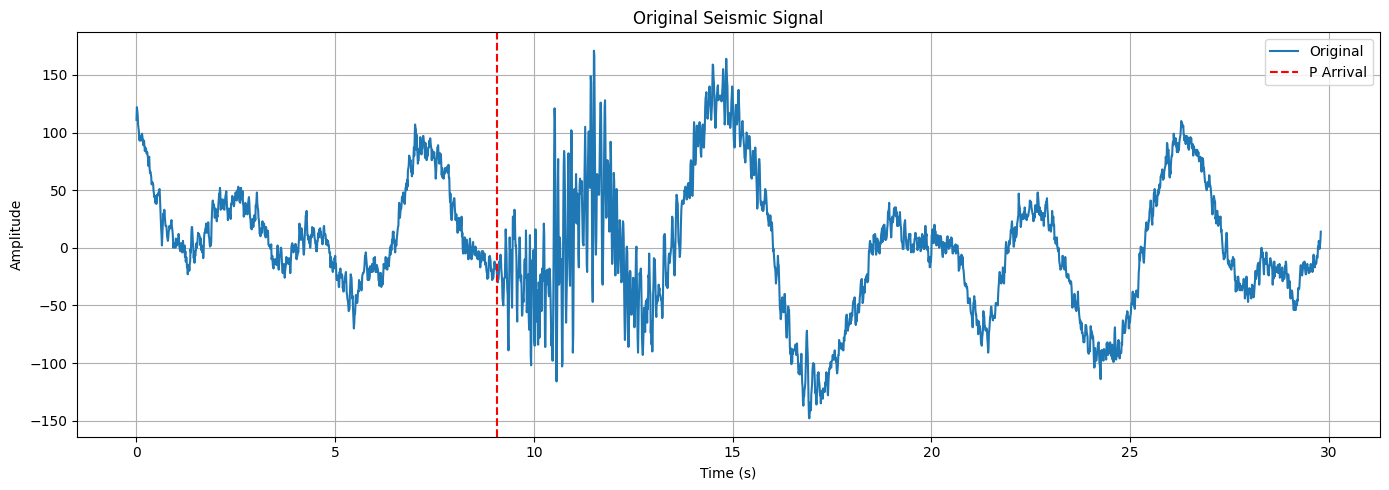

In [13]:
df = read_data_csv()
p_time = get_time(df['archivo'][0])
tr = read_signal(df['archivo'][0])
time_array, arrival_seconds = times_relative(tr, p_time)
print(f"Arrival time: {arrival_seconds} seconds")
plot_signal(tr, arrival_seconds, df['archivo'][0], time_array)




### Z-score Normalization

1. Scale Standardization
- Centers the data around 0 (by subtracting the mean)
- Scales the data so that they have a standard deviation of 1
- Makes amplitudes comparable across different seismic signals
2. Benefits for ML
- Improves training: ML algorithms work better with data at similar scales
- Faster convergence: Helps algorithms converge faster
- Prevents feature dominance: Prevents signals with larger amplitudes from dominating training
3. Advantages for Seismic Analysis
- Allows comparison of signals from different seismic stations
- Reduced variability
- Instrument sensitivity
- Local site conditions
- Distance to source
4. Robustness
- Removes offsets and biases from the data
- Scale-invariant: Results do not depend on the original units
- Shape-preserving: Maintains the signal's shape by standardizing its amplitude

*Formula:*

$$
 z = \frac{(x-μ)}{σ}
$$

- x: original value
- μ: mean of the data
- σ: standard deviation

### Butterworth filter

To inpruve the cuality of the data, i use a digital band-pass filter based on the butterworth filter desing was applied. The objetive of filtering is to attenuate low frequency components (signal drift) and high precuency signas like instrumental or ambiental noise, preserving only the usefull data to detect the arrival time of the P wave. 

THe band-pass filter was designed by combinin a high-pass filter and a low-pass filter, using Butterworth for its smoothly dreasing frequencies. 

$$
∣|H(f)| = \frac{1}{\sqrt{1 + \left( \frac{f}{f_c} \right)^{2n}}}
$$

where fc is the center frecuency of the band and B represent the band widht. This is used in `scipy.singnal.butter`, bufore studing the data the frecuencies what seems made more clear the form of the major porcion of the waves are (lowcut = 7, highcut = 19). The literature put the interval of frecuencies of the P waves between (1, 20hz) depending on several factors. 





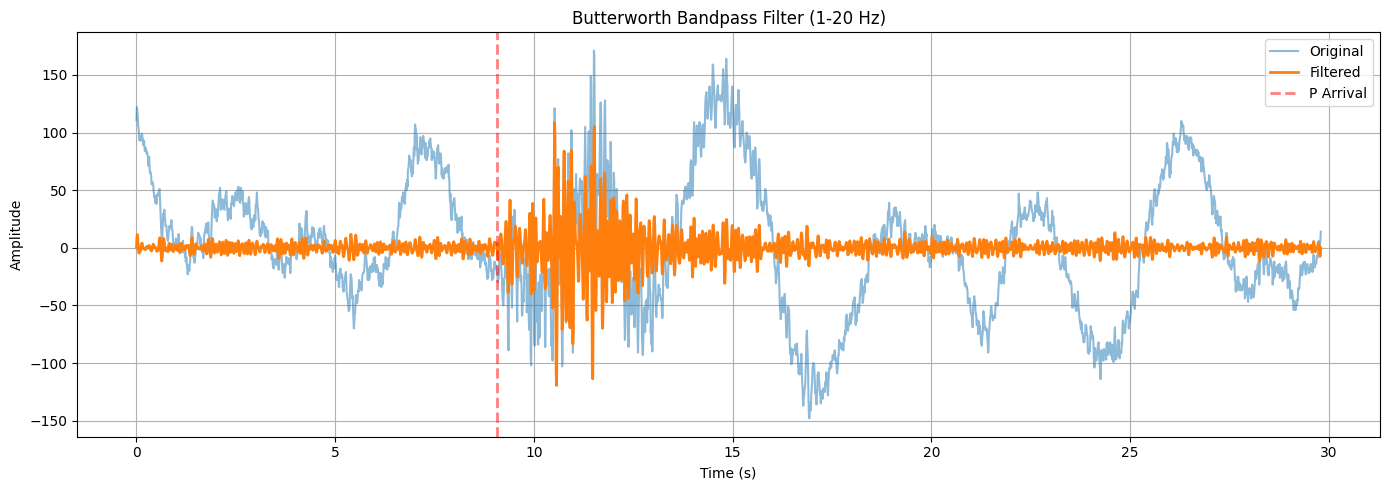

In [5]:
# remove noise of the sismic signal 
filtered_signal = bandpass_filter(tr.data, fs=tr.stats.sampling_rate, lowcut=7, highcut=19)
plot_filter_wave(tr, arrival_seconds, filtered_signal)

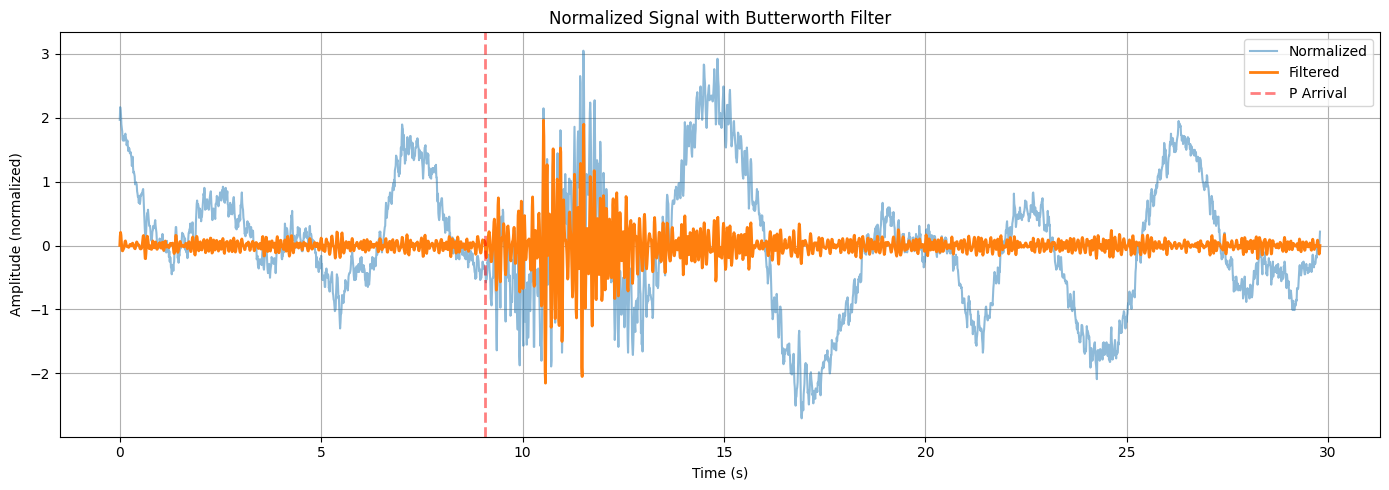

In [16]:
# normalizar la señál
normalized_signal = normalize_signal(tr)
filtered_signal = bandpass_filter(normalized_signal, fs=tr.stats.sampling_rate, lowcut=7, highcut=19)
plot_normalized_and_filtered_wave(tr, arrival_seconds, normalized_signal, filtered_signal)

The pattern of the arrive P wave looks more clearly with the filters than the normal wave. And that happens along all the data. 

### Searching in the data

Some of the data looks like are bad labaled, the arrival time are off side the range in time of the wave. Other hand, it seems that in the train dataset some of them are not-representative, where of the arrival time of the wave in my opnion does not seems follow any pattern. Like the data: 5011733


Arrival time: 30.7 seconds


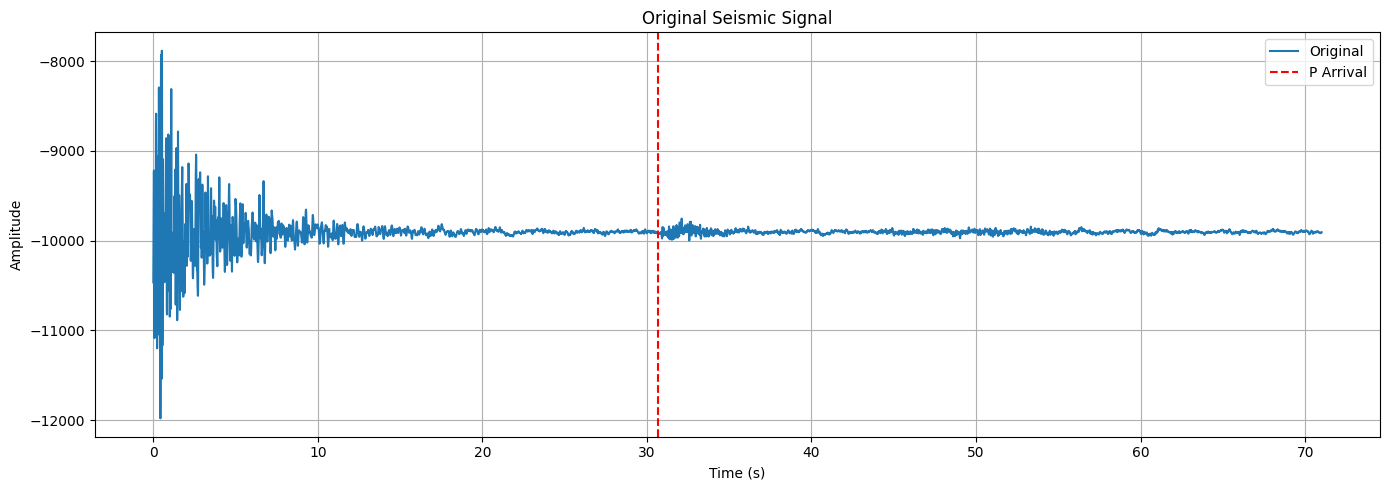

In [216]:
# Try with a valid file from the dataset
not_representative_data = 8221125  # Using first file from dataset as example
p_time = get_time(not_representative_data)
tr = read_signal(not_representative_data)
time_array, arrival_seconds = times_relative(tr, p_time)
print(f"Arrival time: {arrival_seconds} seconds")
plot_signal(tr, arrival_seconds, not_representative_data, time_array)



Arrival time: 30.3 seconds


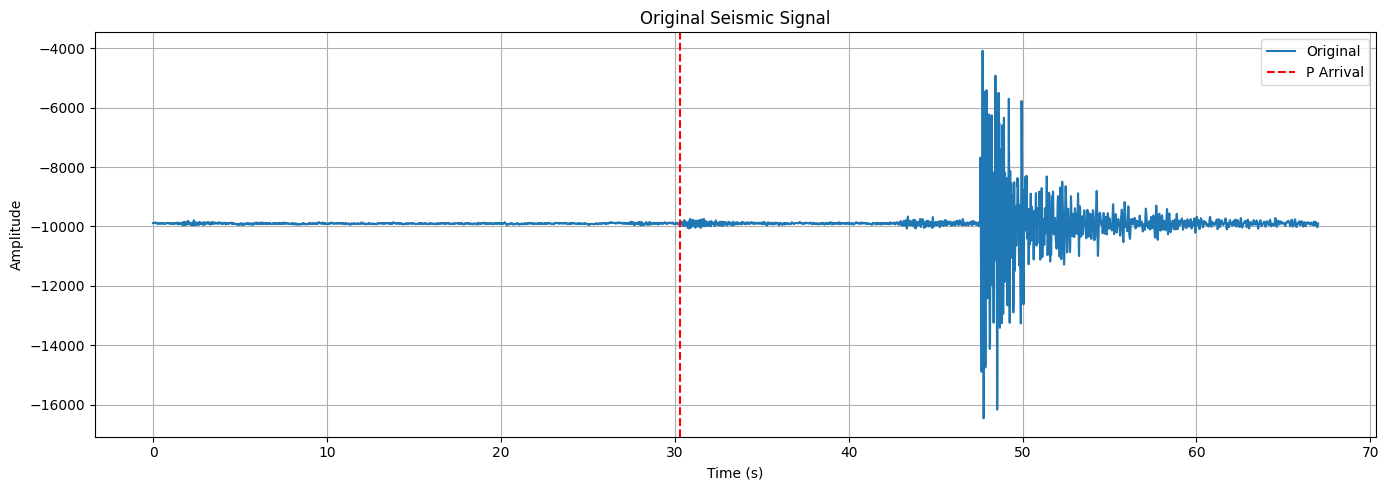

In [217]:
# Try with a valid file from the dataset
not_representative_data = 5011733  # Using first file from dataset as example
p_time = get_time(not_representative_data)
tr = read_signal(not_representative_data)
time_array, arrival_seconds = times_relative(tr, p_time)
print(f"Arrival time: {arrival_seconds} seconds")
plot_signal(tr, arrival_seconds, not_representative_data, time_array)


I notice 12 examples what i didn't see a pattern clearly, the ids are in the csv (/data/procesed/not_representative_data.csv). This examples i will implement by now in the train set, but i need a opion of the observatory


Arrival time: 30.8 seconds


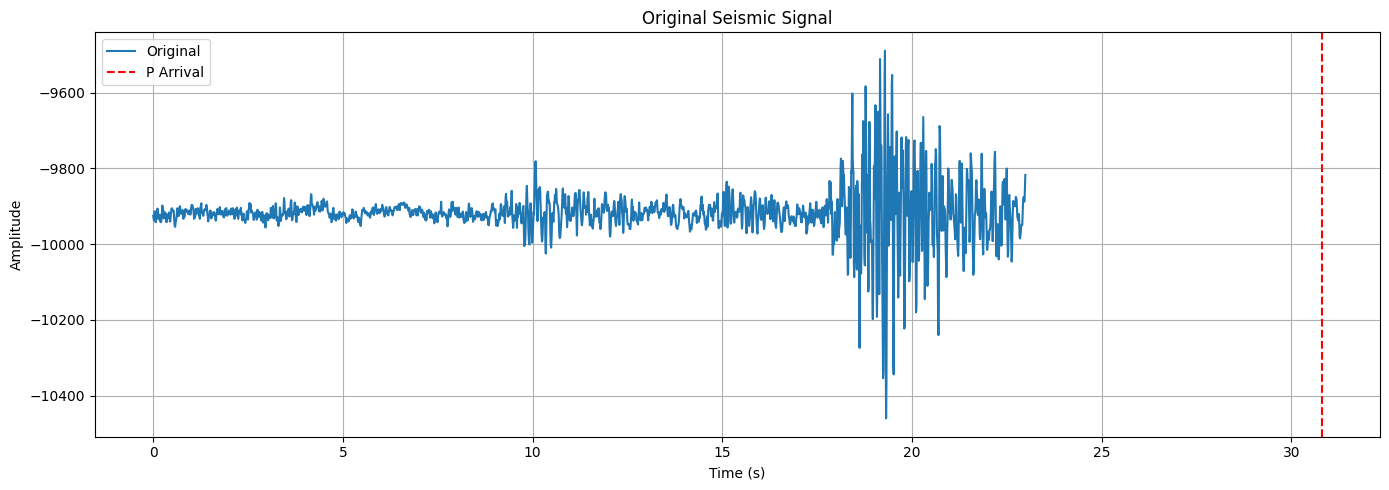

In [218]:
not_labaled_data = 5010731
p_time = get_time(not_labaled_data)
tr = read_signal(not_labaled_data)
time_array, arrival_seconds = times_relative(tr, p_time)
print(f"Arrival time: {arrival_seconds} seconds")
plot_signal(tr, arrival_seconds, not_labaled_data, time_array)

Arrival time: 68.8 seconds


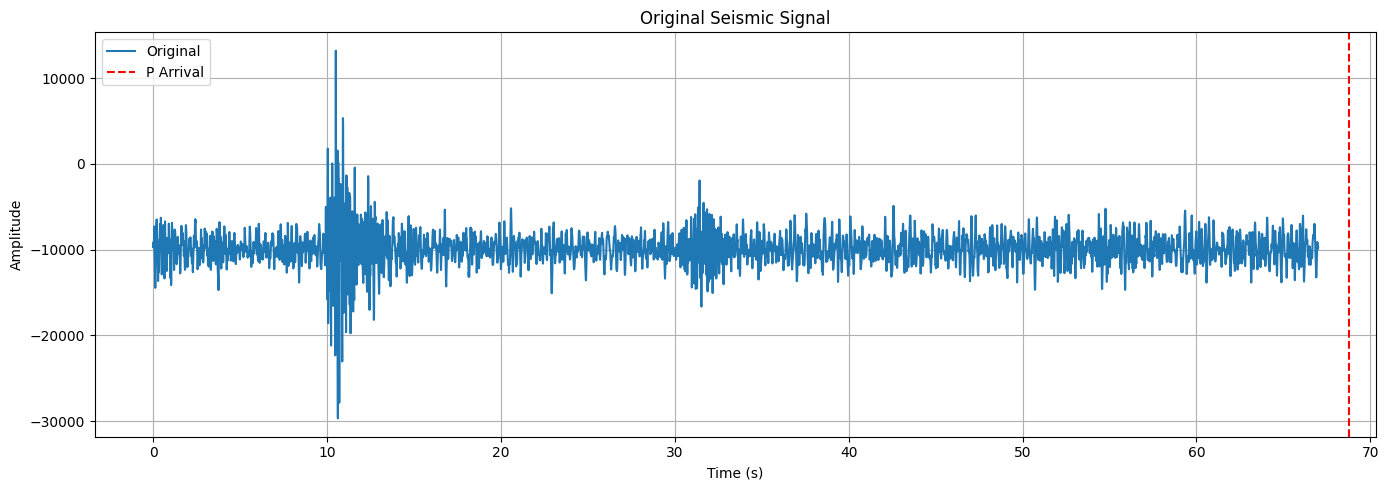

In [219]:
not_labaled_data = 1200517
p_time = get_time(not_labaled_data)
tr = read_signal(not_labaled_data)
time_array, arrival_seconds = times_relative(tr, p_time)
print(f"Arrival time: {arrival_seconds} seconds")
plot_signal(tr, arrival_seconds, not_labaled_data, time_array)

Both examples (1200517, 5010731) has bad labaled data, are out of range (/data/procesing/unlabeled_data.csv). I see 24 examples like this in the train dataset, so at the time of procesing is better remove this data to impruve the cuality of the data and so on the inference of the model Cnns+wavelets.

To export of that data i use the repository sismic-waves-visualizer but i also implement the logic in this project the path is src/procesing/validate.py.

>Note: I use this repository: [sismic-waves-visualizer](https://github.com/Camgomocod/SeismicWavesVisualizer) the project is made by me and is all documented in the repo, make me easily view and study all the data, allowing me notice these things, like not-representative data, and unlabaled data. 


In [17]:
df.head()

,eve_fecha,archivo,lec_p
0,2024-04-01 03:55:42.000,4010355,1.711944e+09
1,2024-04-01 09:19:05.000,4010919,1.711963e+09
2,2024-04-01 09:36:45.000,4010936,1.711964e+09
3,2024-04-01 17:49:27.000,4011749,1.711994e+09
4,2024-04-02 01:30:23.000,4020130,1.712021e+09
